# 환경설정

In [34]:
import torch

# 1. CUDA 사용 가능 여부 확인
cuda_available = torch.cuda.is_available()
print(f"가상환경에서 GPU 사용 가능 여부: {cuda_available}")

if cuda_available:
    # 2. 현재 사용 중인 GPU 장치 번호와 이름 확인
    current_device = torch.cuda.current_device()
    device_name = torch.cuda.get_device_name(current_device)
    print(f"현재 사용 중인 장치 번호: {current_device}")
    print(f"그래픽카드 모델명: {device_name}")

    # 3. CUDA 버전 및 메모리 상태 확인
    print(f"CUDA 버전: {torch.version.cuda}")
    
    # 메모리 단위 변환 (바이트 -> 기가바이트)
    total_mem = torch.cuda.get_device_properties(current_device).total_memory / 1e9
    allocated_mem = torch.cuda.memory_allocated(current_device) / 1e9
    reserved_mem = torch.cuda.memory_reserved(current_device) / 1e9
    
    print(f"전체 VRAM 용량: {total_mem:.2f} GB")
    print(f"현재 AI 모델이 점유 중인 메모리: {allocated_mem:.2f} GB")
    print(f"PyTorch가 예약한(캐시) 메모리: {reserved_mem:.2f} GB")
    print(f"남은 여유 공간: {(total_mem - reserved_mem):.2f} GB")
else:
    print("⚠️ GPU를 찾을 수 없습니다. 드라이버나 PyTorch 설치를 확인해 주세요.")

가상환경에서 GPU 사용 가능 여부: True
현재 사용 중인 장치 번호: 0
그래픽카드 모델명: NVIDIA GeForce RTX 3060 Laptop GPU
CUDA 버전: 12.1
전체 VRAM 용량: 6.44 GB
현재 AI 모델이 점유 중인 메모리: 1.57 GB
PyTorch가 예약한(캐시) 메모리: 1.95 GB
남은 여유 공간: 4.49 GB


In [35]:
# 설치(import)
import os
import gc
import re
from PIL import Image
from transformers import AutoProcessor, LlavaOnevisionForConditionalGeneration, BitsAndBytesConfig
from tqdm.notebook import tqdm # 노트북용 진행 바 추가

# 전처리 전용 import
import cv2
import numpy as np
import matplotlib.pyplot as plt


# [필수] 메모리 파편화 방지 및 관리 설정
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def clean_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

clean_memory()
print("준비 완료!")

준비 완료!


# **전처리**

In [36]:
def show_comparison(original, processed):
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.title("Processed (For OCR)")
    plt.imshoe(processed, cmap='gray')
    plt.axis('off')
    plt.show()

In [37]:
def preprocess_for_varco(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print('파일을 찾을수 없습니다!')
        return None
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)
    blurred = cv2.GaussianBlur(enhanced, (3, 3), 0)
    binary = cv2.adaptiveThreshold(
        blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 21, 10
    )

    show_comparison(img, binary)

    return Image.fromarray(binary).convert("RGB")

AttributeError: module 'matplotlib.pyplot' has no attribute 'imshoe'

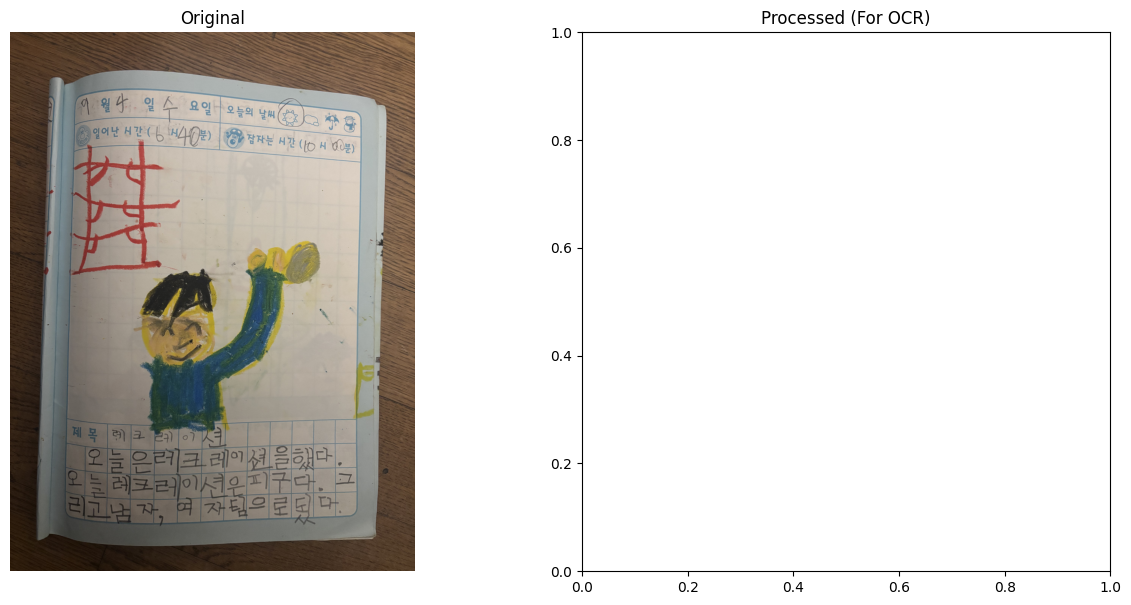

In [38]:
target_file = "img1.jpg"

clean_image = preprocess_for_varco(target_file)

if clean_image:
    target_size = 768
    w, h = clean_image.size
    if max(w, h) > target_size:
        scale = target_size / max(w, h)
        clean_image = clean_image.resize((int(w * scale), int(h * scale)), resample=Image.LANCZOS)

    print("전처리가 완료 되었습니다")

# VARCO VISION 2.0

In [27]:
# 기존에 모델이 메모리에 있다면 삭제 시도 (재실행 시 안전장치)
if 'model' in locals():
    del model
    clean_memory()

model_id = "NCSOFT/VARCO-VISION-2.0-1.7B-OCR"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

print("모델 로딩 중 (VRAM 절약 모드)...")
model = LlavaOnevisionForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    device_map="auto",
    attn_implementation="sdpa",
    low_cpu_mem_usage=True
)
processor = AutoProcessor.from_pretrained(model_id)
print("모델 로드 완료!")

모델 로딩 중 (VRAM 절약 모드)...
모델 로드 완료!


In [28]:
def clean_ocr_text(text):
    # 좌표(소수점 4개 세트) 제거
    cleaned = re.sub(r'\d+\.\d+,\s*\d+\.\d+,\s*\d+\.\d+,\s*\d+\.\d+', '', text)
    # 불필요한 공백 및 줄바꿈 정리
    cleaned = re.sub(r'\s+', ' ', cleaned).strip()
    return cleaned

In [29]:
# 1. 작업할 파일 경로 지정 (파일명을 직접 수정하세요)
# target_file = "img1.jpg" 

if not os.path.exists(target_file):
    print(f"❌ 파일을 찾을 수 없습니다: {target_file}")
else:
    print(f"🔍 '{target_file}' 분석을 시작합니다...")
    
    try:
        # 이미지 로드 및 전처리
        image = Image.open(target_file).convert("RGB")
        
        # 6GB VRAM을 고려한 최적 사이즈 (속도가 너무 느리면 512, 정확도가 중요하면 768)
        target_size = 768 
        w, h = image.size
        if max(w, h) > target_size:
            scale = target_size / max(w, h)
            image = image.resize((int(w * scale), int(h * scale)), resample=Image.LANCZOS)

        # 대화 구성
        conversation = [
            {"role": "user", "content": [{"type": "image", "image": image}, {"type": "text", "text": "<ocr>"}]}
        ]

        # 입력 데이터 변환
        inputs = processor.apply_chat_template(
            conversation, add_generation_prompt=True, tokenize=True, return_dict=True, return_tensors="pt"
        ).to(model.device)

        # 🚀 추론 (속도와 정확도를 위한 최적 설정)
        with torch.inference_mode():
            generate_ids = model.generate(
                **inputs,
                max_new_tokens=1024,
                do_sample=False,   # OCR 속도를 높이기 위해 샘플링 끔
                num_beams=1,      # Greedy search로 최고 속도 유도
                use_cache=True
            )

        # 결과 디코딩 및 정제
        full_output = processor.decode(generate_ids[0][len(inputs.input_ids[0]):], skip_special_tokens=True)
        final_result = clean_ocr_text(full_output)

        print("\n" + "="*30)
        print(f"📄 [파일명: {os.path.basename(target_file)}]")
        print("-" * 30)
        print(final_result)
        print("="*30)

        # 메모리 청소
        del inputs, generate_ids, image
        clean_memory()

    except Exception as e:
        print(f"⚠️ 오류 발생: {e}")
        clean_memory()

🔍 'img1.jpg' 분석을 시작합니다...


Setting `pad_token_id` to `eos_token_id`:151645 for open-end generation.



📄 [파일명: img1.jpg]
------------------------------
열 수 (10) (10) (10)
